In [1]:
import torch
import time
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.optim import optimize_acqf
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
NOISE_SE = 0.25
nrep = 10
device = "cpu"

In [2]:
# the function to be maximized
from botorch.test_functions import Hartmann
neg_hartmann6 = Hartmann(negate = True)

In [3]:
def generate_initial_data(n):
    # generate training data
    train_x = torch.rand(n, 6, device=device, dtype=dtype)
    exact_obj = neg_hartmann6(train_x).unsqueeze(-1)  # add output dimension
    train_obj = exact_obj + NOISE_SE * torch.randn_like(exact_obj)
    best_observed_value = train_x.max().item()
    return train_x, train_obj

In [7]:
neg_hartmann6

tensor([[0.9512, 0.6607, 0.0531, 0.2442, 0.4962, 0.1552],
        [0.0209, 0.0185, 0.7360, 0.5315, 0.4422, 0.0479],
        [0.9545, 0.4832, 0.6507, 0.5632, 0.4650, 0.1933],
        [0.0482, 0.9908, 0.0381, 0.4997, 0.1653, 0.6915],
        [0.2723, 0.6247, 0.6521, 0.6267, 0.3610, 0.1326],
        [0.4163, 0.7497, 0.6873, 0.0411, 0.2363, 0.5046],
        [0.3765, 0.8417, 0.1197, 0.0310, 0.3021, 0.6602],
        [0.3846, 0.8187, 0.4420, 0.5381, 0.9944, 0.7571],
        [0.0894, 0.5559, 0.3926, 0.6871, 0.2014, 0.5308],
        [0.4462, 0.9769, 0.9739, 0.5915, 0.0599, 0.7044]], dtype=torch.float64)

In [4]:
# initialize training data and the model
train_X, train_Y = generate_initial_data(n=10)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll)
UCB = UpperConfidenceBound(gp, beta = 0.1)
bounds = torch.stack([torch.zeros(6, device = device), torch.ones(6, device = device)])
candidate, acq_value = optimize_acqf(
        UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
    )

In [10]:
new_y

tensor([[0.6302]])

In [8]:
best_seen_rep = []
time_list = []

for irep in range(nrep):
    
    train_X, train_Y = generate_initial_data(n = 10)

    gp = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    bounds = torch.stack([torch.zeros(6, device = device), torch.ones(6, device = device)])
    best_observed_value = []
    t0 = time.time()
    
    for iteration in range(40):

        fit_gpytorch_model(mll)

        UCB = UpperConfidenceBound(gp, beta = 2)    
        candidate, acq_value = optimize_acqf(
            UCB, bounds=bounds, q = 1, num_restarts=5, raw_samples=20,
        )
        new_x = candidate.detach()
        print(new_x)
        new_y = neg_hartmann6(new_x).unsqueeze(-1)
        new_y = new_y + NOISE_SE * torch.randn_like(new_y)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
        best_value = neg_hartmann6(train_X).max()
        best_observed_value.append(best_value.cpu())

        # update GP model using dataset with new datapoint
        gp = SingleTaskGP(train_X, train_Y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)


        print(
                f"\nBatch {iteration:>2}: best_value = "
                f"({best_value:>4.2f}), "
            )
    time_list.append(time.time() - t0)
    best_seen_rep.append(np.array(best_observed_value))

tensor([[0.2890, 0.2826, 0.9524, 0.4738, 0.1946, 0.4369]])

Batch  0: best_value = (1.11), 
tensor([[0.2998, 0.1031, 0.9665, 0.3695, 0.2462, 0.6332]])

Batch  1: best_value = (1.42), 
tensor([[0.4315, 0.1898, 0.9158, 0.4452, 0.2453, 0.5873]])

Batch  2: best_value = (1.42), 
tensor([[0.1995, 0.2002, 0.8857, 0.3418, 0.2430, 0.5513]])

Batch  3: best_value = (1.59), 
tensor([[0.1451, 0.2159, 1.0000, 0.3539, 0.1557, 0.5533]])

Batch  4: best_value = (1.59), 


KeyboardInterrupt: 

In [103]:
np.save('Hartmann6_SNR4_UCB2-0_10Prior_10reps.npy', np.array(best_seen_rep))

In [58]:
np.mean(time_list)

20.51214556694031

## Compare between results from BOtorch and SLAC GP

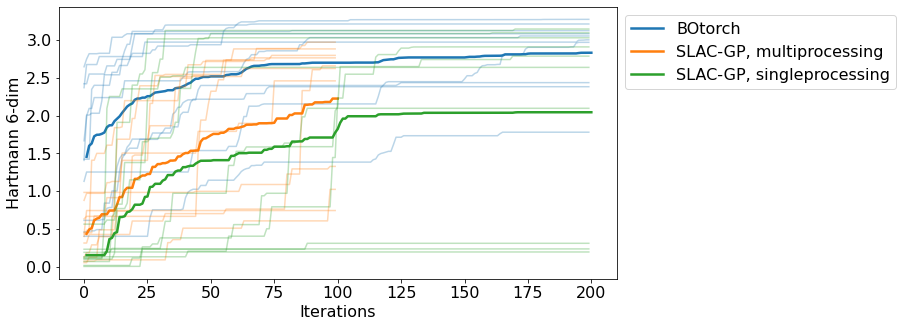

In [113]:
fig, ax = plt.subplots(1,1, figsize = [10, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Hartmann6_SNR2_UCB2-0_10Prior_10reps_200iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
niter = result.shape[1]
ax.plot(np.linspace(1,200, 200), avg, linewidth = 2.5, label = 'BOtorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:niter], c='C0', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR2_UCB2-0_multi_10reps_100iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,100,100), avg, linewidth = 2.5, c = 'C1', label = 'SLAC-GP, multiprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C1', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR2_UCB2-0_single_10reps_200iter.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,200,200), avg, linewidth = 2.5, c = 'C2', label = 'SLAC-GP, singleprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C2', alpha = 0.3)
    
ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Hartmann 6-dim', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize = 16)

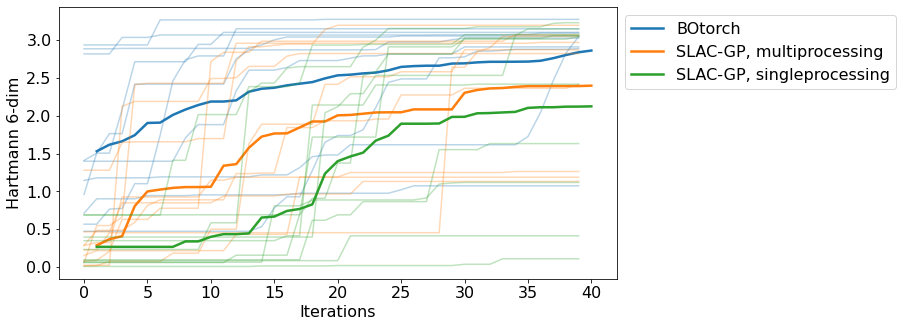

In [104]:
fig, ax = plt.subplots(1,1, figsize = [10, 5])
result_path = '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/'

result = np.load('Hartmann6_SNR4_UCB2-0_10Prior_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, label = 'BOtorch')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c='C0', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR4_UCB2-0_multi_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c = 'C1', label = 'SLAC-GP, multiprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C1', alpha = 0.3)
    
result = np.load(result_path + 'Hartmann6_SNR4_UCB2-0_single_10reps.npy')
avg = np.mean(result, axis = 0)
std = np.std(result, axis = 0)
ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c='C2', label = 'SLAC-GP, singleprocessing')
# ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
for i in range(result.shape[0]):
    ax.plot(result[i,:], c = 'C2', alpha = 0.3)
    
# result = np.load(result_path + 'Hartmann6_SNR2_falseUCB2-0_multi_10reps.npy')
# avg = np.mean(result, axis = 0)
# std = np.std(result, axis = 0)
# ax.plot(np.linspace(1,40,40), avg, linewidth = 2.5, c = 'C3', label = 'SLAC-GP, multiprocessing, false UCB')
# # ax.fill_between(np.linspace(1,40,40), avg - std, avg + std, alpha = 0.3)
# for i in range(result.shape[0]):
#     ax.plot(result[i,:], c='C3', alpha = 0.3)

ax.set_xlabel('Iterations',fontsize = 16)
ax.set_ylabel('Hartmann 6-dim', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1, fontsize = 16)